In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.io import wavfile
from difflib import SequenceMatcher
%matplotlib notebook

In [4]:
with open ("Book3.csv", "r") as f:
    data = f.read()
#data.split("\n")
qbank = []

for line in data.split("\n"):
    #rint(line)
    if ',' not in line:
        continue
    q,a = line.strip().split(',')
    if a[0].lower() == "t":
        qbank.append((q,True))
    else:
        qbank.append((q,False))

for line in qbank:
    print(line)

('The universe is 13.8 billion years old.', True)
('The constellation Virgo is the hottest place in the universe.', True)
('Jupiter is the largest planet in our solar system.', True)
('Apollo 17 was the last NASA manned mission space filght to the moon.', True)
('There is only one moon in our solar system.', False)
('The shortest space flight was 25 minutes.', False)
('Light cannot escape from a black hole.', True)
('There are 9 planets in the solar system.', False)
('Red supergiant stars are the largest type of stars in the universe.', True)
('Elliptical galaxies are not the most common galaxies in the universe.', False)
('An ant can fit 100 times its own weight.', False)
('8128 is a perfect number.', True)
('There are 24 time zones in the world.', True)
('AB postitive is the rarest blood type in humans.', False)
('An octopus has only one heart.', False)
('Hydrogen is the first element on the periodic table.', True)
('There are seven colors in a rainbow.', True)
('Dolphins cannot smel

In [5]:
def clean_function(R):
    Fs = 10000;
    T = np.linspace(1, len(R), len(R))/Fs
    nffte = len(T)
    X = np.fft.fft(R,nffte)
    X = np.fft.fftshift(X)

    f = np.linspace(-nffte/2,nffte/2-1,len(X))*Fs/nffte


    X[abs(f)>15]=0

    R1 = np.fft.ifftshift(X)
    R = np.fft.ifft(R1)
    return R

def normalize(R):
    #transfer to normalize graph
    max_r = max(R)
    min_r = min(R)
    if abs(min_r) > max_r:
        max_r = abs(min_r)
    for index in range(len(R)):
        R[index] /= max_r
    plt.figure()
    plt.plot(R)
    return R

In [6]:
#detect events
def event_function(R,Fs):    
    window_size = Fs*1
    start_point = 0
    event_list = []
    var_list = []
    var_start = 0
    
    while True:
        if var_start+len(R)/Fs/10 >= len(R):
            break
        win = R[int(var_start):int(var_start+Fs/2)]
        var_list.append(np.var(win))
        var_start+=len(R)/Fs/3

    while True:
        if start_point+window_size<=len(R):
            window = R[int(start_point):int((start_point+window_size/2))]
            window_var = np.var(window)
            if window_var >= 0.062:
                event_list.append(start_point)
                start_point+=Fs*1.25
            else:
                start_point += len(R)/Fs/3
            if start_point+len(R)/Fs/3 >=len(R):
                break
        else:
            break
#     print(len(event_list))
#     print(event_list)
#     plt.figure()
#     plt.plot(var_list)
    return event_list
#detect direction
def direction_function(event_list,Fs):    
    direction_list = []
    for event in event_list:
        event_period = R[int(event):int(event+Fs/2)]
        max_pos=np.argwhere(R==max(event_period))
        min_pos=np.argwhere(R==min(event_period))
        if max_pos <min_pos:
            direction_list.append("L")
        else:
            direction_list.append("R")
#     print(direction_list)
#     print(np.mean(var_list))
    return direction_list
#machine learning
def point_interval(event_list,R,Fs):
    result_list = []
    for ele in event_list:
        result_list.append(R[int(ele):int(ele+Fs/2)])
    return result_list   
def randomforest(event_list):    
    features = np.array(event_list).astype(float)
    labels = [1,1,1,1,0,0,0,0]
    #labels = [1,1,0,0,0,0,1,1,1,1,0,0,0,0]
    
    labels = np.array(labels)
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    rf.fit(features,labels)
    return rf



<IPython.core.display.Javascript object>


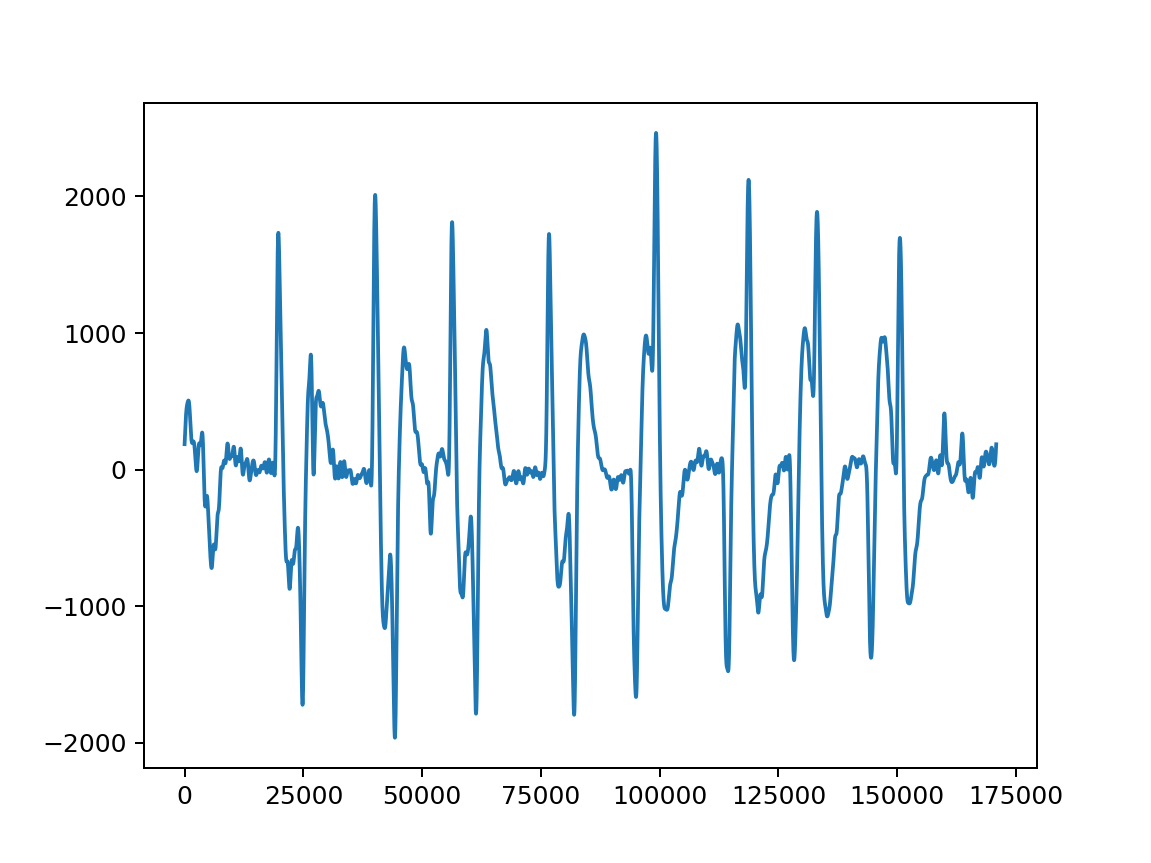

<IPython.core.display.Javascript object>


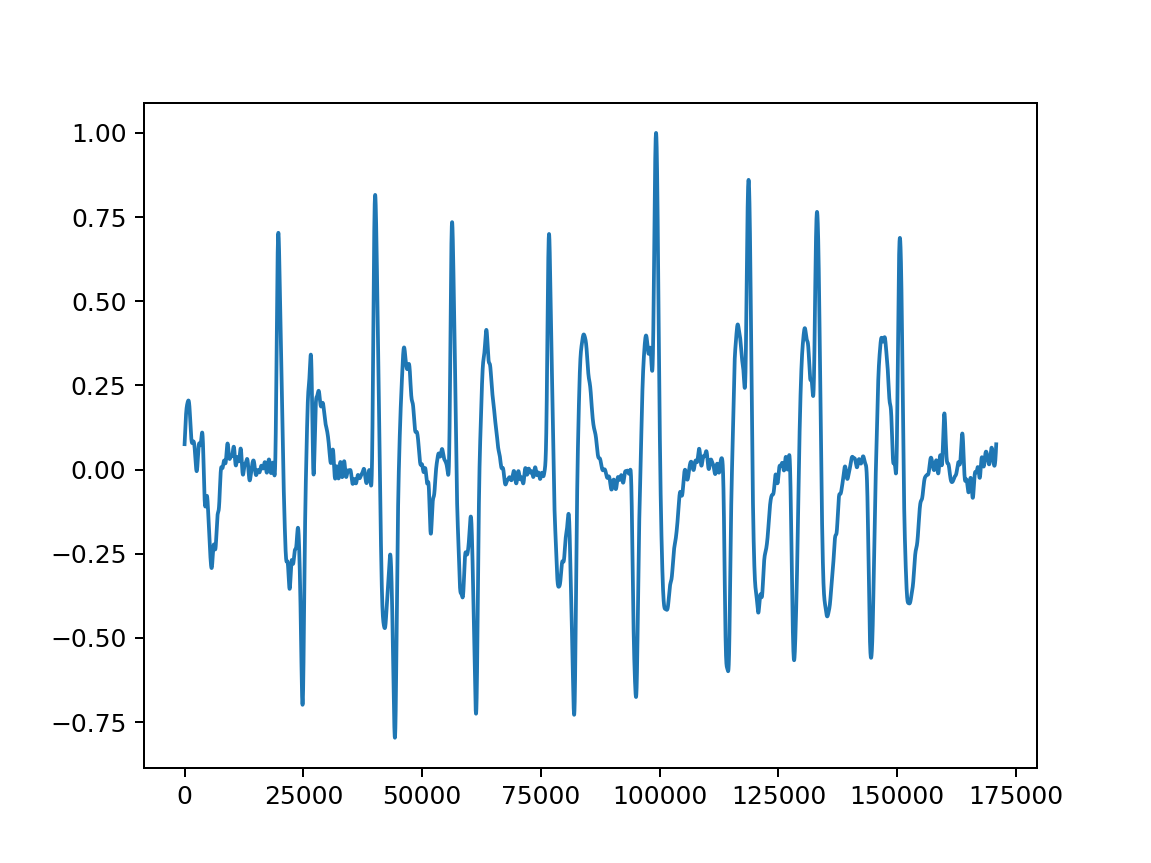

<IPython.core.display.Javascript object>


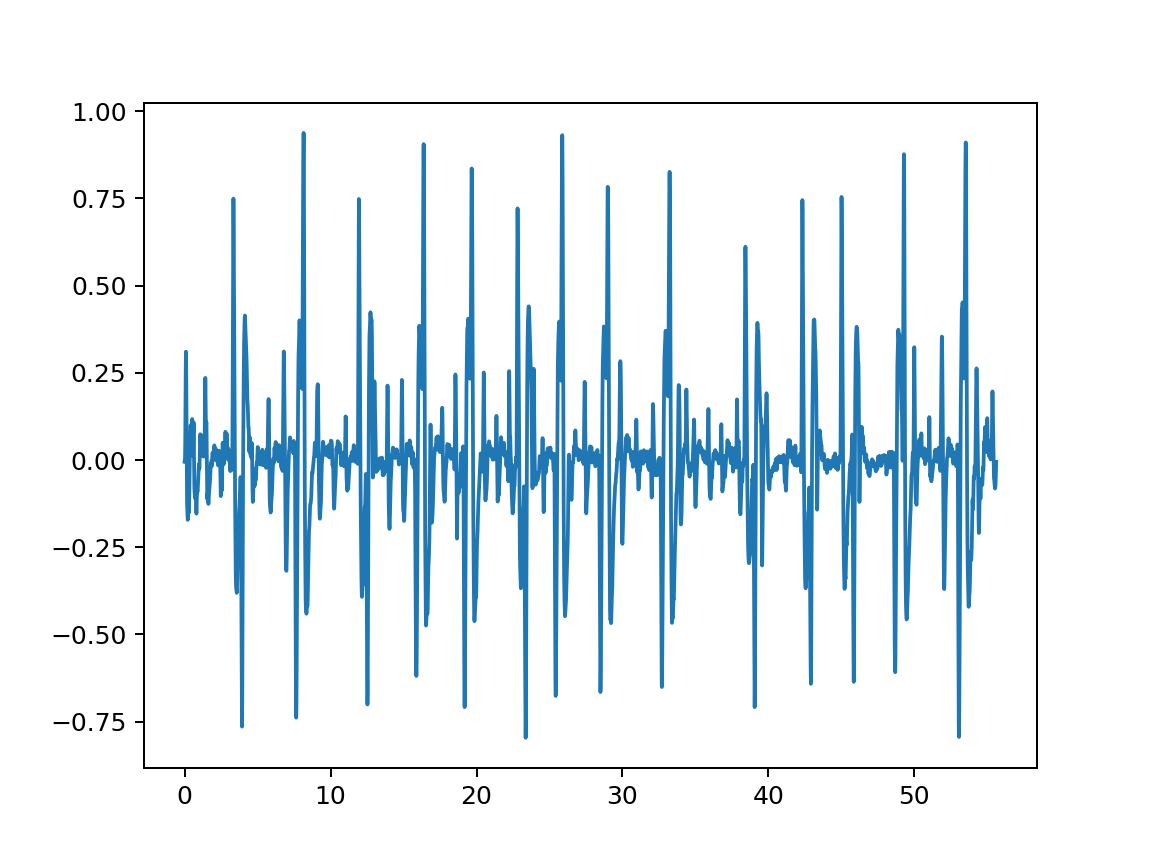

In [7]:
from scipy.io import wavfile
[Fs,R]=wavfile.read('new calibrate.wav')
#[Fs,R]=wavfile.read('regular calibration 2 end.wav')
Rsequence = [1,1,1,1,0,0,0,0];
Rsequence1 = [0,0,0,0,1,1,1,1];
#Rsequence = [1,1,0,0,0,0,1,1,1,1,0,0,0,0];

threshold = np.linspace(0.2,0.5,100)


R = clean_function(R)#R is calibration 


maxR = max(abs(R))
T = np.linspace(1, len(R), len(R))/Fs;
tsave = [];

for d in range(len(threshold)):

    TWindow = 0.05;    # observation interval
    threshold_level = threshold[d];

    TMax = max(T);  # maximum time recorded
    dT = T[1]-T[0]; # dT
    NWindow = TWindow/dT;   # number of points in Window
    delay_time = TWindow;   # wait the "recording interval" time
    Ra = R/maxR;

    r = [];
    time = [];
    RT = [];
    reset = 0;
    

    a = round(TMax/TWindow)

    for k in range(int(a)):



        window_index_beginning = 1+NWindow*(k);
        window_index_end = NWindow+NWindow*(k);
        window_index_range = np.linspace(window_index_beginning,window_index_end,window_index_end-window_index_beginning+1)


        blinkstest = max(abs(Ra[int(window_index_beginning):int(window_index_end)]));


        average_signal = sum(Ra[int(window_index_beginning):int(window_index_end)])/len(window_index_range);


        if reset % 30 == 0:
            reset = 0;


        if reset == 0:
            if blinkstest > 1.3:
                r = np.append(r,5);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;
            elif average_signal>threshold_level:
                r = np.append(r,1);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;
            elif average_signal<-threshold_level:
                r = np.append(r,0);
                time = np.append(time,[TWindow*(k+1)]);
                reset = 1;

        else:
            reset = reset + 1; 



    RT = np.stack((r, time))

    RT = RT.transpose()
    
    acca = SequenceMatcher(None, r, Rsequence);
    acca = acca.ratio()
    
    acca1 = SequenceMatcher(None,r,Rsequence1)
    acca1 = acca1.ratio()
    
    #print(RT)
    
    if acca == 1:
        tsave = np.append(tsave,threshold_level)
        sign = 1;
    elif acca1 == 1:
        tsave = np.append(tsave,threshold_level)
        sign = -1;
   

     
fourfive = round(0.8*len(tsave))
trem = tsave
threshold_level = tsave[int(fourfive)]


fig = plt.figure()
plt.plot(R)
R = normalize(R)
event_list = event_function(R,Fs)
# direction_list = direction_function(event_list,Fs)
event_interval = point_interval(event_list,R,Fs)
rf = randomforest(event_interval)


from scipy.io import wavfile
[Fs,Y]=wavfile.read('LR softblink 1.wav')
#[Fs,Y]=wavfile.read('LR softblink 2.wav')
#[Fs,Y]=wavfile.read('LR softblink 3.wav')
#[Fs,Y]=wavfile.read('LR softblink 4.wav')
#[Fs,Y]=wavfile.read('LR softblink 5.wav')
#[Fs,Y]=wavfile.read('LR softblink 6.wav')
#[Fs,Y]=wavfile.read('LR softblink 7.wav')
#[Fs,Y]=wavfile.read('LR softblink 8.wav')
#[Fs,Y]=wavfile.read('LR softblink 9.wav')

#[Fs,Y]=wavfile.read('regular calibration 2 end.wav')


#[Fs,Y]=wavfile.read('LR hardblink 1.wav')
#[Fs,Y]=wavfile.read('LR hardblink 2.wav')
#[Fs,Y]=wavfile.read('LR hardblink 3.wav')
#[Fs,Y]=wavfile.read('LR hardblink 4.wav')
#[Fs,Y]=wavfile.read('LR hardblink 5.wav')
#[Fs,Y]=wavfile.read('LR hardblink 6.wav')
#[Fs,Y]=wavfile.read('LR hardblink 7.wav')


Y = clean_function(Y)/maxR



T = np.linspace(1, len(Y), len(Y))/Fs

fig5 = plt.figure(5)
plt.plot(T,Y)


In [8]:
threshold_level

0.34545454545454546

In [9]:
#METHOD 1


TMax = max(T);  # maximum time recorded
TWindow = 0.05;    # observation interval
#threshold_level = 0.40;
dT = T[1]-T[0]; # dT
NWindow = int(round(TWindow/dT));   # number of points in Window

import time
r = [];
rime = [];
RTtrue = [];
reset = 0;
reset_2 = 0;
reset_3 = 0;


import random


p = 0
random.shuffle(qbank)
correct = 0
s = 0

print("Left = True, Right = False\n")
q,a = qbank[p]
print(p+1,q)

#Run time: int(round(50/TWindow))
c = round(len(Y)/Fs)-1



for i in range(0,int(c/TWindow)):
    #time.sleep(0.05)
    if i>=20: 
        
        if reset_2 != 0:
            if reset_2 % 140 == 0:
                #print new question
                q,a = qbank[p]
                #print ('\n')
                print(p+1,q)
                reset_2 = 0;
            elif reset_2 == 20:
                print('6 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
            elif reset_2 == 40:
                print('5 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
            elif reset_2 == 60:
                print('4 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
            elif reset_2 == 80:
                print('3 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
            elif reset_2 == 100:
                print('2 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
            elif reset_2 == 120:
                print('1 second\r',end='',flush=True)
                reset_2 = reset_2 + 1;
                
            else:
                reset_2 = reset_2 + 1;
            
        elif reset_2 == 0:
            if reset != 0:
                if reset % 30 == 0:
                    #print new question
                    q,a = qbank[p]
                    #print('\n')
                    print(p+1,q)
                    reset = 0;
                elif reset == 20:
                    print('1 second\r',end='',flush=True)
                    reset = reset + 1;
                else:
                    reset = reset + 1;
  

        if reset ==0:
            if reset_2 == 0:
            
                r = [];
                rime = [];


                window_index_beginning = int(1+NWindow*(i)); # test if needs 1 or not
                window_index_end = int(NWindow+NWindow*(i));


                blinkstest = max(abs(sign*Y[window_index_beginning:window_index_end]));


                average_signal = sum(sign*Y[window_index_beginning:window_index_end])/(window_index_end-window_index_beginning+1)



      

                if reset_3 == 0:

                    if blinkstest > 1.3:
                        print('You skipped')
                        print(q,a,'\n')
                        #r = np.append(r,'Blink');
                        r = np.append(r,'5')
                        rime = np.append(rime,[TWindow*(i+1)]);
                        #reset = 1
                        reset_2 = 1;
                        reset_3 = 1;
                        p += 1
                        s += 1
                        #q,a = qbank[p]

                if reset_2 == 0:
                    if average_signal>threshold_level:

                        #r = np.append(r,'Left');
                        r = np.append(r,'1')
                        rime = np.append(rime,[TWindow*(i+1)]);
                        reset = 1;
                        usera= True
                        #usera = bool(usera)
                        # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                        if usera == bool(a):
                            print("You said True, that is correct")
                            correct+= 1
                            #print(q,a)

                        else:
                            print("You said True, that is Incorrect")
                            #print(q,a)

                        print(q,a,'\n')
                        p += 1
                        #q,a = qbank[p]    
                        #print(p+1,q)
                        reset_3 = 0

                    elif average_signal<-threshold_level:

                        #r = np.append(r,'Right');
                        r = np.append(r,'0')
                        rime = np.append(rime,[TWindow*(i+1)]);
                        reset = 1;
                        usera= False
                        #usera = bool(usera)
                        # --- set user = none, while it's none, have the spiker box scan for signals; set a while loop to 
                        if usera == bool(a):
                            print("You said False, that is correct")
                            #print(q,a)
                            correct+= 1  

                        else:
                            print("You said False, that is incorrect")
                            #print(q,a)
                            #d.pop(a[0])
                        print(q,a,'\n')
                        p += 1
                        #q,a = qbank[p]
                        #print(p+1,q)
                        reset_3 = 0
                    #else:
                        #reset = reset + 1


                RT = np.stack((r, rime))

                RT = RT.transpose()  


                RTtrue = np.append(RTtrue,RT)


            

    
print(RTtrue)
    
print("Time is up!", "Your Score:", correct, "Out of", p-s, ", Skipped:", s)

Left = True, Right = False

1 Apollo 17 was the last NASA manned mission space filght to the moon.
You said True, that is correct
Apollo 17 was the last NASA manned mission space filght to the moon. True 

2 There are 9 planets in the solar system.
You said False, that is correct
There are 9 planets in the solar system. False 

3 There have been 50 U.S. Presidents.
You said True, that is Incorrect
There have been 50 U.S. Presidents. False 

4 Christopher Columbus discovered the New World in 1592.
You said False, that is correct
Christopher Columbus discovered the New World in 1592. False 

5 Liver is the largest organ of human body.
You said False, that is correct
Liver is the largest organ of human body. False 

6 8128 is a perfect number.
You said True, that is correct
8128 is a perfect number. True 

7 Zimbabwe was known as Rhodesia from 1964 to 1980.
You said False, that is incorrect
Zimbabwe was known as Rhodesia from 1964 to 1980. True 

8 ROM stands for read only memory in compu

In [11]:
#METHOD 2 MACHINE LEARNING



import random


p = 0
random.shuffle(qbank)
correct = 0
s = 0

print("Left = True, Right = False\n")
q,a = qbank[p]
# print(p+1,q)

#Run time: int(round(50/TWindow))
c = round(len(Y)/Fs)-1





            
r = [];
rime = [];



average_signal = sum(Y)/(len(Y))

event_point = event_function(Y,10000)
events = point_interval(event_point,Y,10000)
user_answer = np.array(events).astype(float)


 
correct = 0
answer_list = []
print(len(user_answer))
for num in range(0,len(user_answer)):
    q,a = qbank[num]
    print(p+1,q)
    user_result = rf.predict([user_answer[num]])

    if user_result > 0.4:
        answer_list.append(True)

        if a == True:
            
            r.append('correct')
            correct+=1
        else:
            r.append('not correct')
    else:
        answer_list.append(False)

        if a == False:
            r.append('correct')
            correct+=1
        else:
            r.append('not correct')
    print(r[len(r)-1],answer_list[len(answer_list)-1],a)
    print()
    p += 1

    
print(r)
print(answer_list)
print("Time is up!", "Your Score:", correct, "Out of", p-s, ", Skipped:", s)
print('First boolean is user input, second is true answer')







Left = True, Right = False

14
1 GUI stands for Graphical user interface in computer science.
correct True True

2 8128 is a perfect number.
correct True True

3 SQL stands for Selected Query Language.
not correct True False

4 SRGB has a wider range of colors than AdobeRGB.
correct False False

5 The shortest space flight was 25 minutes.
correct False False

6 There are seven colors in a rainbow.
correct True True

7 Apollo 17 was the last NASA manned mission space filght to the moon.
not correct False True

8 Light cannot escape from a black hole.
not correct False True

9 Saint Patrick's Day was originally associated with color red.
correct False False

10 The Titanic sank in 1913.
not correct True False

11 The name for the Greek goddess of victory is called Nike.
correct True True

12 The constellation Virgo is the hottest place in the universe.
correct True True

13 ROM stands for read only memory in computer memory.
not correct False True

14 Celsius and Fahrenheit are equal at 